We will be using PyTorch for this neural network, so we need to import it.

In [1352]:
import torch
import torch.nn as nn
import torch.nn.functional as F

For the neural network, we will have a 10-neuron input layer (representing 10 independent variables) and a 2-neuron output layer (representing "stroke=no" and "stroke=yes"). We will also include 4 hidden layers, each with 8 neurons. The activation function used throughout the network will be the Rectified Linear Unit (ReLU).

> I attempted to enhance the model's performance by incorporating Dropout functions, but it did not yield improvement.

Finally, we apply a softmax function to the output layer to generate a probability distribution, allowing us to observe the model's predicted probability of stroke.

In [1353]:
class Model(nn.Module):
  def __init__(self, input=10, h1=8, h2=8, h3=8, h4=8, output=2):
    super().__init__()
    self.fc1 = nn.Linear(input, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.fc4 = nn.Linear(h3, h4)
    self.out = nn.Linear(h4, output)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.softmax(self.out(x), dim=-1)


    return x

We will need to instantiate the model in order to train and test it.

In [1354]:
model = Model()

We import Pandas in order to read the dataset and Matplotlib for plotting.

In [1355]:
import pandas as pd
import matplotlib.pyplot as plt
# In order to see plots in the notebook
%matplotlib inline

We import the dataset as a pandas' Dataframe.



In [1356]:
url = 'healthcare-dataset-stroke-data.csv'
my_df = pd.read_csv(url)
my_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


When printing the information about this dataset, we can observe that some columns have a Dtype of "object," indicating that they most likely contain strings. Additionally, upon closer inspection, we can see that the "bmi" column has some null values, meaning that some entries are NaNs (Not a Number) instead of float64 values. Finally, we will need to separate the "stroke" column from the rest, as it represents the dependent variable (what we are trying to predict).

In [1357]:
# We drop id and stroke columns since we won't use ids and we don't want the column stroke in our independent matrix.
X = my_df.drop(["id", "stroke"], axis=1)

# We set numeric values for strings.
X["gender"] = X["gender"].replace(["Male", "Female", "Other"], [0.0, 1.0, 2.0])
X["ever_married"] = X["ever_married"].replace(["No", "Yes"], [0.0, 1.0])
X["work_type"] = X["work_type"].replace(["children", "Govt_job", "Never_worked", "Private", "Self-employed"], [0.0, 1.0, 2.0, 3.0, 4.0])
X["Residence_type"] = X["Residence_type"].replace(["Rural", "Urban"], [0.0, 1.0])
X["smoking_status"] = X["smoking_status"].replace(["formerly smoked", "never smoked", "smokes", "Unknown"], [0.0, 1.0, 2.0, 3.0])

# We replace the bmi NaNs with the column's median.
X["bmi"].fillna(X["bmi"].median(), inplace = True)
y = my_df['stroke']
X = X.values
y = y.values


We import sklearn in order to use the ***train_test_split*** functionality to separate the data in **train samples** and **test samples**.

In [1358]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Now we need to convert the output of the train_test_split, which are NumPy arrays, to PyTorch tensors. We will convert our X to float in order to fit PyTorch's default tensor data type, which is float32. For the y arrays, we will convert them to integers to fit in a LongTensor, which is a tensor with a data type of long int and only holds 0s or 1s.

In [1359]:
# We convert arrays to tensors.
X_train = torch.Tensor(X_train.astype(float))
X_test = torch.Tensor(X_test.astype(float))
y_train = torch.LongTensor(y_train.astype(int))
y_test = torch.LongTensor(y_test.astype(int))

When developing this neural network, I encountered a problem: there is a significant underrepresentation of people with strokes in the dataset. The imbalance is so pronounced that the model achieved a 95% accuracy by simply predicting "no stroke" for every input.

In [1360]:
# If we print the number of no_strokes and strokes we see its alarmingly different.
y_train.unique(return_counts=True)

# We calculate the rate of strokes in order to adjust it weights in the Cross Entropy Loss function.
zeros = y_train.unique(return_counts=True)[1][0].item()
ones = y_train.unique(return_counts=True)[1][1].item()
frequencies = torch.tensor([zeros, ones])
weights = 1.0 / frequencies

We will now use the weights we just calculated to adjust the weights in our error function. For our optimizer, we will use the Adam optimizer, which incorporates an adaptive learning rate.

In [1361]:
criteria = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Now it's time for training! We will set a number of iterations, which will determine the number of times we pass the X_train tensor to our model. Then, using the Cross Entropy Loss function, we will calculate the error of our prediction and save it in a list for later plotting.

In [1362]:
iterations = 150
losses = []
for i in range(iterations):

  y_pred = model(X_train)
  loss = criteria(y_pred, y_train)
  losses.append(loss.detach().numpy())

  if i % 10 == 0:
    print(f'Iteration {i} with loss {loss}.')

  # We backpropagate the error and reset gradients of previos backpropagations
  optimizer.zero_grad()
  loss.backward()
  # Finally we update the optimizer values with the new gradients
  optimizer.step()


Iteration 0 with loss 0.7009556889533997.
Iteration 10 with loss 0.669378399848938.
Iteration 20 with loss 0.6164638996124268.
Iteration 30 with loss 0.5813131928443909.
Iteration 40 with loss 0.5575527548789978.
Iteration 50 with loss 0.5425562262535095.
Iteration 60 with loss 0.5365927815437317.
Iteration 70 with loss 0.5334328413009644.
Iteration 80 with loss 0.5308762788772583.
Iteration 90 with loss 0.5288407802581787.
Iteration 100 with loss 0.5271535515785217.
Iteration 110 with loss 0.5251691341400146.
Iteration 120 with loss 0.5254151225090027.
Iteration 130 with loss 0.5240132212638855.
Iteration 140 with loss 0.523676335811615.


Now we plot the losses to visualize the progression of the errors. It's evident that it plateaus at 0.5 error.

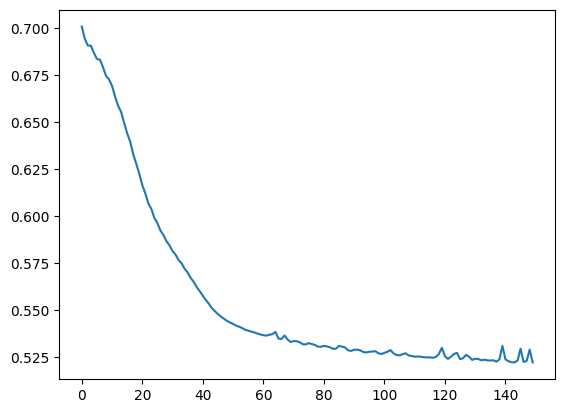

In [1363]:
plt.plot(losses)

Now we will test the newly trained model with our test data. We will also count our misses and identify what was mispredicted in order to gain insight into the performance of our model.

> When fine-tuning this model, I believe it's better to prioritize correctly identifying strokes, even if that means mispredicting strokes for people who are not going to have one, for obvious reasons.

In [1364]:
correct = 0
actually1 = 0
actually0 = 0
with torch.no_grad():
  for i, data in enumerate(X_test):
    y_eval = model.forward(data)

    if (y_eval.argmax().item() == y_test[i]):
      correct += 1
    else:
      # Actually1 is when the model guessed no_stroke and the outcome was stroke. (BAD)
      if (y_test[i] == 1):
        actually1 += 1
        print(f'I computed {y_eval} which means that I guessed stroke: {y_eval.argmax().item()}, but actually stroke: {y_test[i]}')
      # Actually0 is when the model guessed stroke and the outcome was no_stroke. (LESS BAD)
      else:
        actually0 += 1

  print(f'Evaluation finished with a total of: {correct} correct guesses and {i - correct} wrong guesses. Total {correct*100/i}% of correct guesses.')
  print(f'I missed {actually1} strokes and misdiagnosed {actually0} fake strokes.')
  zeros = y_test.unique(return_counts=True)[1][0].item()
  ones = y_test.unique(return_counts=True)[1][1].item()
  print(f'That is a {actually1*100/ones}% of missed strokes and a {actually0*100/zeros}% of misdiagnosed fake strokes.')


I computed tensor([0.9929, 0.0071]) which means that I guessed stroke: 0, but actually stroke: 1
I computed tensor([0.9595, 0.0405]) which means that I guessed stroke: 0, but actually stroke: 1
I computed tensor([0.9550, 0.0450]) which means that I guessed stroke: 0, but actually stroke: 1
I computed tensor([0.6071, 0.3929]) which means that I guessed stroke: 0, but actually stroke: 1
I computed tensor([0.5705, 0.4295]) which means that I guessed stroke: 0, but actually stroke: 1
I computed tensor([0.9909, 0.0091]) which means that I guessed stroke: 0, but actually stroke: 1
I computed tensor([0.5879, 0.4121]) which means that I guessed stroke: 0, but actually stroke: 1
I computed tensor([0.7161, 0.2839]) which means that I guessed stroke: 0, but actually stroke: 1
I computed tensor([0.6306, 0.3694]) which means that I guessed stroke: 0, but actually stroke: 1
I computed tensor([0.7103, 0.2897]) which means that I guessed stroke: 0, but actually stroke: 1
I computed tensor([0.9460, 0.0

Here you can try the model for urself putting in your own data :)

In [1365]:
with torch.no_grad():
  data = torch.tensor([0.0, 20.0, 0.0, 0.0, 0.0, 1.0, 1.0, 100.0, 21, 1.0])
  y_eval = model.forward(data)
  if (y_eval[0] < y_eval[1]):
    print("Bad news buddy.")
  else:
    print("Chilling.")
  print(y_eval)

Chilling.
tensor([9.9971e-01, 2.8652e-04])


### Thanks for passing by :)))